11 weight layer, 19 weight layer 등 다양
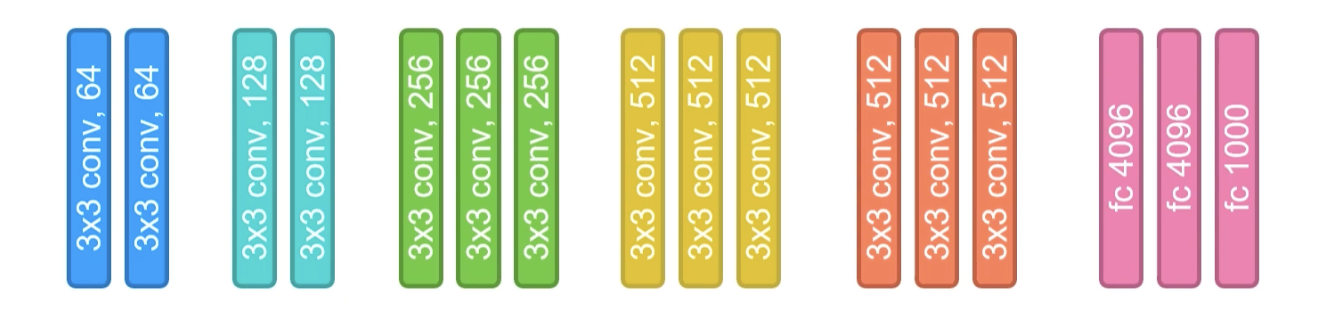
특징: 3x3 Conv, stride=1, padding=1

torchvision.models.vgg

- vgg11~vgg19까지 만들 수 있음

- 입력 기준: 3x224x224

라이브러리 가져오기

In [17]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo

modelurl: pytorch에서 VGG에 대해 pretraining 시켜놓은 모델들

In [18]:
__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]


model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
    'vgg13_bn': 'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
    'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',
}

In [26]:
class VGG(nn.Module):
  def __init__(self, features, num_classes = 1000, init_weights=True):
    super(VGG, self).__init__()

    self.features = features #features는 쌓아나가야 할 VGG의 Conv layer들
    self.avgpool = nn.AdaptiveAvgPool2d((7,7))
    #classifier는 fully-connected layer들
    self.classifier = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, num_classes)
    )

    def forward(self, x):
        x = self.features(x) #Conv
        x = self.avgpool(x) # avgpooling
        x = x.view(x.size(0), -1) #한줄로 펼치기
        x = self.classifier(x) #FC layer통과
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d): #Conv라서 kaiming normal로 초기화
                #어떤 activate function을 쓰느냐에 따라 weight초기화를 잘할 수 있다.
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                #VGG에선 bias가 0이다.
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)#linearfunction일 경우, 그에 맞게 normalize
                nn.init.constant_(m.bias, 0)

feature 값을 어떻게 만들어서 넣을 수 있을까

- make layer

- cfg

In [20]:
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3 #input채널 3으로 고정

    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    return nn.Sequential(*layers)

``` PYTHON
'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

model = make_layer[cfg['A'], batch_norm=False]
conv8+fc3 = VGG11

conv2d = nn.Conv2d(3, 64, kernel_size=3, padding=1) 통과 후 채널size 64로 변경됨
nn.ReLU(inplace=True)

nn.MaxPool2d(kernel_size=2, stride=2)

conv2d = nn.Conv2d(64, 128, kernel_size=3, padding=1) 통과 후 채널size 128로 변경됨
nn.ReLU(inplace=True)

nn.MaxPool2d(kernel_size=2, stride=2)

conv2d = nn.Conv2d(128, 256, kernel_size=3, padding=1)통과 후 채널size 256로 변경됨
nn.ReLU(inplace=True)

conv2d = nn.Conv2d(256, 256, kernel_size=3, padding=1)통과 후 채널size 256로 변경됨
nn.ReLU(inplace=True)

nn.MaxPool2d(kernel_size=2, stride=2)

conv2d = nn.Conv2d(256, 512, kernel_size=3, padding=1)통과 후 채널size 256로 변경됨
nn.ReLU(inplace=True)

conv2d = nn.Conv2d(512, 512, kernel_size=3, padding=1)통과 후 채널size 256로 변경됨
nn.ReLU(inplace=True)

nn.MaxPool2d(kernel_size=2, stride=2)

conv2d = nn.Conv2d(512, 512, kernel_size=3, padding=1)통과 후 채널size 256로 변경됨
nn.ReLU(inplace=True)

nn.MaxPool2d(kernel_size=2, stride=2)
```

In [21]:
conv = make_layers(cfg['A'])
conv

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): ReLU(inplace=True)
  (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU(inplace=True)
  (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (16): Conv2d(512, 512, kernel_size=(3, 3), stride=

In [22]:
cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], #8 + 3 =11 == vgg11
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], # 10 + 3 = vgg 13
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'], #13 + 3 = vgg 16
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'], # 16 +3 =vgg 19
    'custom' : [64,64,64,'M',128,128,128,'M',256,256,256,'M'] #내가 원하는거 작성
}

In [23]:
conv = make_layers(cfg['custom'])
conv

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU(inplace=True)
  (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): Conv2d(2

`batch_norm=True` 로 하면 Conv 다음에 바로 batch normalize

In [24]:
conv = make_layers(cfg['custom'],batch_norm=True)
conv

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats

cifar10에 적용 - class가 10개

In [27]:
CNN = VGG(make_layers(cfg['custom']),num_classes=10,init_weights=True)
CNN

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), paddin

이미지 크기가 다른 data에 적용하려면

classifier에서 nn.Linear(512 * 7 * 7, 4096) 부분을 수정해줘야한다.